In [43]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from scipy import stats, optimize

In [44]:
def create_master_dark(file_template, num_frames):
    """
This line defines a function named create_master_dark that takes two parameters: 
file_template and num_frames.
file_template: A string that contains the file path template for the dark frame files, 
with a placeholder for the frame number.
num_frames: An integer representing how many dark frames will be processed.

    Create a master dark frame by median-combining dark frames.
    
    :param file_template: Template path for the dark frame files with placeholders for the frame number.
    :type file_template: str
    :param num_frames: The number of dark frames to combine.
    :type num_frames: int
    :return: Master dark frame (2D numpy array), Stack of individual dark frames (3D numpy array)
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # List to store the data from each dark frame
    dark_frames_data = []

    # Initializes an empty list called dark_frames_data, 
    # which will be used to store the pixel data from each individual dark frame.


    # Loop through each dark frame and read the data
    for i in range(num_frames):
        #starts a loop that will iterate num_frames times. 
        # The variable i will take values from 0 to num_frames - 1. 
        # This is used to process each dark frame individually.

        # Construct the file name based on the frame number
        file_path = file_template.format(i)

        # This line uses the file_template.format(i) method to generate the file path 
        # for the i-th dark frame by replacing the placeholder in file_template with the value of i. 
        # For example, if i = 5, it will generate a file path like 
        # ..\FITS_Files\3.2.3_10_dark_frames_30_sec.00000005.DARK.FIT.

        # Open the FITS file and extract the data
        with fits.open(file_path) as hdul:
            dark_frames_data.append(hdul[0].data)
        # Uses the fits.open() function from the astropy.io.fits library 
        # to open the FITS file specified by file_path. 
        # The opened file is stored in hdul, which stands for Header Data Unit List.

    # Stack the frames into a 3D array "stacked_frames"(stack of 2D frames)
    # Each slice along the first axis (axis=0) corresponds to a different dark frame.
    stacked_frames = np.stack(dark_frames_data, axis=0)
    # This line calculates the median pixel value across all frames for each pixel position. 
    # It uses np.median() along the first axis (axis=0), which corresponds to the stack of frames. 
    # The result is a 2D array called master_dark_frame that represents the final master dark frame.
    master_dark_frame = np.median(stacked_frames, axis=0)
    
    return master_dark_frame, stacked_frames


# Template for the file names (with placeholder for frame number)
file_template = r"..\FITS_Files\3.2.3_10_dark_frames_30_sec.{:08d}.DARK.FIT"
# This defines the file_template, 
# which contains the file path format with a placeholder ({:08d}) for the frame number.

# Number of dark frames to combine
num_frames = 10
# Create the master dark frame and get the individual frames
master_dark_frame, dark_frames = create_master_dark(file_template, num_frames)

In [45]:
# Calculate the median value of the master dark frame
median_value = np.median(master_dark_frame)

# Output the median value
print(f"Median value of the master dark frame: {median_value}")

Median value of the master dark frame: 1022.0


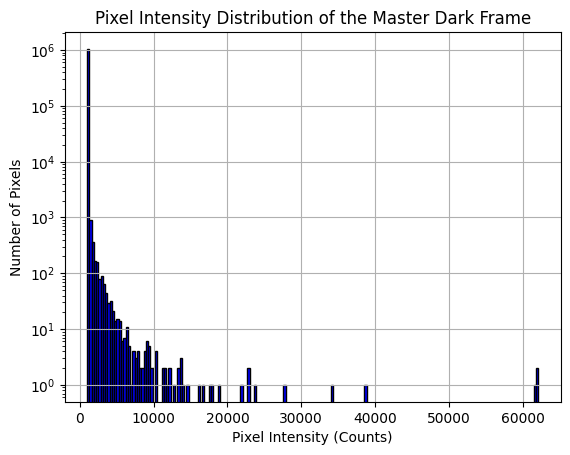

In [46]:
# Flattening the data into a 1D array
flattened_data = master_dark_frame.flatten()

# This line takes the 2D array master_dark_frame and flattens it into a 1D array.
# The .flatten() method in numpy returns a copy of the array collapsed into one dimension. 
# Instead of working with a 2D grid of pixel intensities, 
# the data is now in a single list, where each pixel's value is an element.

# Plot the histogram of pixel intensities for the median dark frame
plt.figure()
plt.hist(flattened_data, range = (np.min(flattened_data), np.max(flattened_data)), bins=200, log=True, color='blue', edgecolor='black')
plt.title('Pixel Intensity Distribution of the Master Dark Frame')
plt.xlabel('Pixel Intensity (Counts)')
plt.ylabel('Number of Pixels')
plt.grid(True)
# This line adds a grid to the plot, making it easier to read values from the axes.

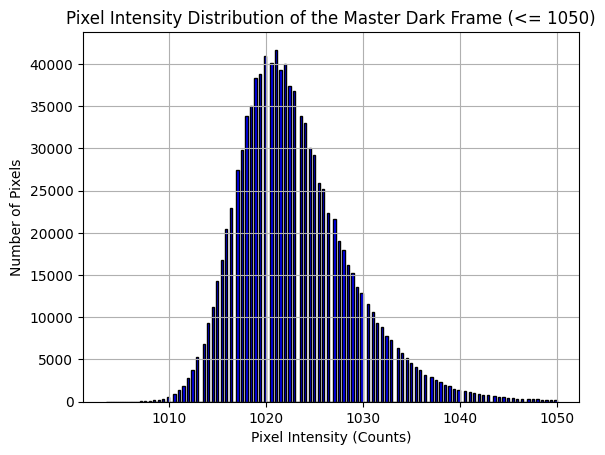

In [47]:
# Filtering the data to include only values less than or equal to the median maximum
med_max = 1050
# sets a threshold value of 1050 for the pixel intensities.
# med_max is set to be the maximum pixel intensity value to include in the analysis. 
# Any pixel with an intensity greater than this value will be filtered out.
filtered_data = flattened_data[flattened_data <= med_max]
# This line filters the flattened pixel intensity data to include 
# only the values that are less than or equal to the med_max threshold.

# Plot the new histogram 
plt.figure()
# This line initializes a new figure for the filtered data histogram. 
# It ensures that the new plot is drawn on a separate canvas.
plt.hist(filtered_data, range = (np.min(filtered_data), np.max(filtered_data)), bins=200, color='blue', edgecolor='black')
plt.title('Pixel Intensity Distribution of the Master Dark Frame (<= 1050)')
plt.xlabel('Pixel Intensity (Counts)')
plt.ylabel('Number of Pixels')
plt.grid(True)

In [48]:
# Initialize lists for hot and warm pixels
hot_pixels = []
warm_pixels = []
# These two lines initialize empty lists, hot_pixels and warm_pixels, 
# to store the coordinates of pixels that meet specific intensity criteria 
# (hot and warm pixels).

# Iterate over each pixel in the median dark frame
for i in range(master_dark_frame.shape[0]):
    for j in range(master_dark_frame.shape[1]):
        if master_dark_frame[i, j] >= 20000:  # Hot pixel threshold
            hot_pixels.append([i, j])  # Store as [row, col] (i, j)
        # This block checks if a pixel’s intensity at coordinates (i, j) is greater than or equal to 20000. 
        # If it is, the pixel is considered a "hot" pixel.

        elif 10000 < master_dark_frame[i, j] < 20000:  # Warm pixel range
            warm_pixels.append([i, j])  # Store as [row, col] (i, j)
        # This block checks if the pixel intensity falls within the range of 
        # 10000 < pixel value < 20000, classifying the pixel as "warm."
        # Warm pixels have moderate intensity values 
        # (higher than the typical background noise but not as extreme as hot pixels).

# Calculate the total number of pixels in the median dark frame
total_pixels = master_dark_frame.size
# master_dark_frame.size gives the total number of elements (pixels) in the 2D array, 
# which is equivalent to the product of the number of rows and columns (height × width).

# Calculate the fraction of rejected pixels
fraction_of_rejected_pixels = (len(hot_pixels) + len(warm_pixels)) / total_pixels
# This line calculates the fraction of "rejected" pixels, 
# which includes both hot and warm pixels.

# len(hot_pixels) + len(warm_pixels) gives the total number of hot and warm pixels.

# Dividing this by total_pixels gives the fraction of the 
# total image that consists of these rejected pixels.

# Output the results
print(f"Hot pixels: {hot_pixels}")
print(f"Warm pixels: {warm_pixels}")

Hot pixels: [[67, 968], [189, 347], [350, 36], [359, 705], [409, 329], [495, 198], [610, 230], [718, 468], [915, 766], [1022, 31]]
Warm pixels: [[28, 129], [77, 1023], [87, 911], [110, 5], [216, 431], [321, 153], [327, 395], [383, 665], [396, 913], [400, 444], [402, 464], [443, 329], [490, 453], [497, 265], [551, 987], [565, 909], [608, 987], [660, 95], [687, 949], [797, 107], [833, 641], [858, 263], [909, 662], [967, 889], [992, 374], [998, 550]]


In [49]:
# Initialize lists for visibility checks
hot_pixels_in_all_frames = []
# Stores the coordinates of hot pixels that appear in all dark frames.
warm_pixels_in_all_frames = []
# Stores the coordinates of warm pixels that appear in all dark frames.
hot_pixels_in_median_only = []
# Stores the coordinates of hot pixels that appear only in the master dark frame 
# (median frame), but not in all individual dark frames.
warm_pixels_in_median_only = []
# Stores the coordinates of warm pixels that appear only in the master dark frame 
# (median frame), but not in all individual dark frames.
hot_pixels_in_both = []
# Stores the coordinates of hot pixels that appear in 
# both the median frame and some (but not all) dark frames.
warm_pixels_in_both = []
# Stores the coordinates of warm pixels that appear in 
# both the median frame and some (but not all) dark frames.

# These six lists are initialized to store the 
# coordinates of hot and warm pixels based on different conditions

# Check each pixel in the list of hot and warm pixels
for pixel in hot_pixels:
    i, j = pixel
    # This loop iterates over all coordinates in the hot_pixels list.
    # i, j = pixel unpacks the row and column coordinates of each hot pixel, 
    # assigning the row index to i and the column index to j.
    appears_in_all_frames = all(dark_frame[i, j] >= 20000 for dark_frame in dark_frames)
    # This line checks if the current hot pixel (located at (i, j)) appears as a hot pixel in all dark frames.
    # The all() function returns True if the pixel's value is greater than or equal to 20000 in every dark frame 
    # (dark_frames is a 3D array containing all individual dark frames).
    appears_in_median_only = (master_dark_frame[i, j] >= 20000) and not appears_in_all_frames
    # This line checks if the current hot pixel appears as a 
    # hot pixel in the median dark frame but not in all individual dark frames.
    # The condition master_dark_frame[i, j] >= 20000 ensures that the pixel is hot in the median frame.
    # 'not appears_in_all_frames' ensures that it is not hot in all individual dark frames.

    # Based on the checks, the pixel is classified into one of three categories:
    if appears_in_all_frames:
        hot_pixels_in_all_frames.append(pixel)
        # If the pixel appears in all dark frames, it is appended to hot_pixels_in_all_frames.
    elif appears_in_median_only:
        hot_pixels_in_median_only.append(pixel)
        # If the pixel appears only in the median frame but not in all individual frames, 
        # it is appended to hot_pixels_in_median_only.
    else:
        hot_pixels_in_both.append(pixel)   
        # Otherwise, the pixel appears in both the median frame and some (but not all) individual frames, 
        # and is appended to hot_pixels_in_both.

for pixel in warm_pixels:
    i, j = pixel
    # This loop iterates over all coordinates in the warm_pixels list.
    # Just like the hot pixel loop, it unpacks the row and column coordinates of each warm pixel.
    appears_in_all_frames = all(10000 < dark_frame[i, j] < 20000 for dark_frame in dark_frames)
    # This line checks if the current warm pixel (located at (i, j)) appears as a warm pixel in all dark frames.
    # The condition checks if the pixel intensity is between 10000 and 20000 in all individual dark frames. If so, the pixel is consistently warm.
    appears_in_median_only = (10000 < master_dark_frame[i, j] < 20000) and not appears_in_all_frames
    # This line checks if the current warm pixel appears as a warm pixel in the median dark frame but not in all individual dark frames.
    # The condition ensures the pixel is warm in the median frame but not in every individual frame.
    
    # Based on the conditions, the pixel is classified into one of three categories:
    if appears_in_all_frames:
        warm_pixels_in_all_frames.append(pixel)
        # If it appears in all frames, it is added to warm_pixels_in_all_frames.
    elif appears_in_median_only:
        warm_pixels_in_median_only.append(pixel)
        # If it only appears in the median frame, it is added to warm_pixels_in_median_only.
    else:
        warm_pixels_in_both.append(pixel)
        # Otherwise, it is added to warm_pixels_in_both.
    

# Output the results
print(f"Hot pixels in all frames: {hot_pixels_in_all_frames}")
print(f"Warm pixels in all frames: {warm_pixels_in_all_frames}")
print(f"Hot pixels only in median: {hot_pixels_in_median_only}")
print(f"Warm pixels only in median: {warm_pixels_in_median_only}")
print(f"Hot pixels in both median and some frames: {hot_pixels_in_both}")
print(f"Warm pixels in both median and some frames: {warm_pixels_in_both}")

Hot pixels in all frames: [[67, 968], [189, 347], [350, 36], [359, 705], [409, 329], [495, 198], [610, 230], [718, 468], [915, 766], [1022, 31]]
Warm pixels in all frames: [[28, 129], [77, 1023], [87, 911], [110, 5], [216, 431], [321, 153], [327, 395], [396, 913], [400, 444], [490, 453], [497, 265], [551, 987], [565, 909], [608, 987], [660, 95], [687, 949], [797, 107], [833, 641], [858, 263], [909, 662], [967, 889], [992, 374], [998, 550]]
Hot pixels only in median: []
Warm pixels only in median: [[383, 665], [402, 464], [443, 329]]
Hot pixels in both median and some frames: []
Warm pixels in both median and some frames: []


In [50]:
def combine_dark_frames_with_bias(dark_file_template, exposure_times, bias_file):

# This function processes dark frames with varying exposure times 
# by adding the pixel data from each dark frame to the bias frame. 

# The function combine_dark_frames_with_bias processes multiple dark frames, 
# each with a different exposure time, and adds the pixel data of these dark frames to the pixel data of a bias frame.

# dark_file_template: A string template used to construct the file path for the dark frames.
# exposure_times: A list of different exposure times for the dark frames.
# bias_file: The file path to the bias frame.

# Returns two 3D numpy arrays:
# A stack of the combined dark and bias frames.
# A stack of the individual dark frames.

    """
    Combine dark frames with varying exposure times with the bias frame by adding their data together.
    
    :param dark_file_template: Template path for the dark frame files with placeholders for the exposure time.
    :type dark_file_template: str
    :param exposure_times: List of exposure times for the dark frames.
    :type exposure_times: list
    :param bias_file: Path to the bias frame FITS file.
    :type bias_file: str
    :return: Stacked combined dark and bias frames (3D numpy array), Stacked individual dark frames (3D numpy array)
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Open the bias frame and get the data
    with fits.open(bias_file) as hdul_bias:
        bias_data = hdul_bias[0].data
# This block opens the bias frame file and reads its pixel data into a numpy array (bias_data).
# fits.open(bias_file): Opens the FITS file specified by bias_file.
# hdul_bias[0].data: Extracts the pixel data from the first HDU (Header/Data Unit) of the bias frame.

    # Initialize lists to hold the combined data and individual dark frame data
    combined_data = []
    individual_dark_frames = []

    # Two empty lists are initialized:
    # combined_data: Will store the pixel data of each combined dark + bias frame.
    # individual_dark_frames: Will store the pixel data of each individual dark frame.

    # Loop over each exposure time and process the corresponding dark frame
    for exposure_time in exposure_times:
        # Construct the file path for the current dark frame
        dark_file_path = dark_file_template.format(exposure_time)
        # Constructs the file path for the dark frame by 
        # inserting the current exposure_time into the template dark_file_template.

        # Open the dark frame and get the data
        with fits.open(dark_file_path) as hdul_dark:
            dark_data = hdul_dark[0].data
        # Store the individual dark frame data
        individual_dark_frames.append(dark_data)
        # Add the dark frame to the bias frame
        combined_frame = dark_data + bias_data
        # Store the combined frame data
        combined_data.append(combined_frame)
    # Stack the combined frames and individual dark frames into 3D arrays
    stacked_combined_data = np.stack(combined_data, axis=0)
    stacked_individual_dark_frames = np.stack(individual_dark_frames, axis=0)

    # After processing all dark frames, the lists 'combined_data' and 'individual_dark_frames' are stacked into 3D arrays.
    # np.stack(combined_data, axis=0): Combines the list of 'combined dark' + 'bias frames' into a 3D array 
    # where each 2D frame is stacked along the first axis.
    # np.stack(individual_dark_frames, axis=0): Similarly, stacks the individual dark frames into a 3D array.

    
    return stacked_combined_data, stacked_individual_dark_frames
    # The function returns two 3D numpy arrays:
    # stacked_combined_data: The combined dark and bias frames.
    # stacked_individual_dark_frames: The original dark frames before combination.

# Example usage
dark_file_template = r"../FITS_Files/3.2.2_dark_frame_{:d}_sec.00000000.DARK.FIT"
# dark_file_template: A template for the dark frame file paths, with {:d} as a placeholder for the exposure time.
exposure_times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]  # List of exposure times for the dark frames
# exposure_times: A list of exposure times to process (e.g., 10s, 20s, up to 120s).
bias_file = r"../FITS_Files/3.1_bias.00000011.BIAS.FIT"
# bias_file: The path to the bias frame file.

# Combine the dark frames with the bias frame
stacked_combined_data, stacked_dark_frames = combine_dark_frames_with_bias(dark_file_template, exposure_times, bias_file)
# Calls the function to combine the dark frames with the bias frame, 
# storing the results in stacked_combined_data and stacked_dark_frames.